# CKD Risk Prediction: Comparative Analysis
## Real-Only Model vs. Real + Synthetic Augmented Model

This notebook compares:
1. **Real Data Only** (pretrained models: LR, RF, XGB)
2. **Real + Synthetic Data Combined** (newly trained augmented models)

Primary reporting in this notebook uses **5-fold cross-validation (CV)**:
- Summary table uses **CV mean ± std** metrics
- Plots use **CV out-of-fold predictions** (ROC + confusion matrices)

A **purely real test set** is still loaded for consistency/optional checks, but plots and the main comparison focus on CV metrics.

---

### Analysis Goals
- Load pretrained model trained on real data
- Train a new model on augmented data (real + synthetic)
- Compare **CV performance metrics** between scenarios
- Generate visualizations (CV metrics, CV ROC curves, CV confusion matrices)
- Print and save a comparative CV metrics table


## 1. Imports, Paths, and Configuration


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer,
 )

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional dependency (only needed if you run XGB)
try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported.")

Libraries imported.


In [3]:
# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    # Data paths
    'X_train_preproc_path': '../data/processed/preprocessed/X_train_preproc.csv',
    'X_test_preproc_path': '../data/processed/preprocessed/X_test_preproc.csv',
    'X_synth_path': '../data/synthetic/X_synth_3x_gcopula_preproc.csv',
    'X_train_raw_path': '../data/processed/splits/X_train_raw.csv',
    'X_test_raw_path': '../data/processed/splits/X_test_raw.csv',

    # Label paths
    'y_train_path': '../data/processed/splits/y_train.csv',
    'y_test_path': '../data/processed/splits/y_test.csv',
    'y_synth_path': '../data/synthetic/y_synth_3x_gcopula.csv',

    # Pretrained model paths (Real Only models)
    'model_lr_real_path': '../models/lr.joblib',
    'model_rf_real_path': '../models/rf.joblib',
    'model_xgb_real_path': '../models/xgb.joblib',
}

# ============================================================================
# EXPERIMENT SETTINGS
# ============================================================================
MODEL_NAMES = ['lr', 'rf', 'xgb']  # extendable
RANDOM_STATE = 42
CV_FOLDS = 5

print("Configuration loaded.")
print(f"Models to run: {[m.upper() for m in MODEL_NAMES]}")
print(f"CV folds: {CV_FOLDS}")
print(f"Random state: {RANDOM_STATE}")

Configuration loaded.
Models to run: ['LR', 'RF', 'XGB']
CV folds: 5
Random state: 42


## 2. Load Real Train & Test Features + Labels
(Test set remains purely real; main comparison/plots use CV metrics.)


In [4]:
def read_y_csv(path: str | None) -> pd.Series:
    if not path:
        raise ValueError(
            "y path not provided. Set CONFIG['y_train_path'] / CONFIG['y_test_path'] / CONFIG['y_synth_path']."
        )

    # Robust read: handle both headerless single-column CSV and CSV with a header.
    y_df = pd.read_csv(path, header=None)
    if y_df.shape[1] == 0:
        raise ValueError(f"No columns found in label file: {path}")

    y = y_df.iloc[:, 0]

    # Drop a header-like first row if present
    if y.dtype == object and len(y) > 0:
        first = str(y.iloc[0]).strip().lower()
        if first in {'label', 'labels', 'target', 'y', 'class', 'classification'}:
            y = y.iloc[1:]

    return y.reset_index(drop=True)


def normalize_binary_y(y: pd.Series) -> pd.Series:
    y = y.copy()

    # If it's already numeric 0/1, keep it.
    if pd.api.types.is_numeric_dtype(y):
        unique_vals = set(pd.unique(y.dropna()))
        if unique_vals.issubset({0, 1}):
            return y.astype(int)
        return y

    # Otherwise map common CKD label strings
    y_str = y.astype(str).str.strip().str.lower()
    mapping = {
        'ckd': 1,
        'notckd': 0,
        'yes': 1,
        'no': 0,
        '1': 1,
        '0': 0,
        'true': 1,
        'false': 0,
    }
    y_mapped = y_str.map(mapping)
    if y_mapped.isna().any():
        bad = sorted(set(y_str[y_mapped.isna()].unique()))
        raise ValueError(
            "Unrecognized label values in y. Provide numeric 0/1 labels or update mapping. "
            f"Bad values: {bad[:10]}"
        )
    return y_mapped.astype(int)


def read_x_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Only drop completely empty rows (common when CSV has trailing newlines)
    return df.dropna(how='all').reset_index(drop=True)


# The exact 6 features your models expect (RAW feature names)
FEAT_6 = ['hemo', 'sc', 'al', 'htn', 'age', 'dm']

# 1) Load RAW train/test data for the pretrained pipeline (Scenario A)
X_train_raw = read_x_csv(CONFIG['X_train_raw_path'])
X_test_raw = read_x_csv(CONFIG['X_test_raw_path'])
print(f"Loaded X_train_raw: {X_train_raw.shape}")
print(f"Loaded X_test_raw:  {X_test_raw.shape}")

# 2) Load PREPROCESSED features for the augmented model (Scenario B)
X_train_preproc = read_x_csv(CONFIG['X_train_preproc_path'])
X_test_preproc = read_x_csv(CONFIG['X_test_preproc_path'])
print(f"Loaded X_train_preproc: {X_train_preproc.shape}")
print(f"Loaded X_test_preproc:  {X_test_preproc.shape}")

# Labels (shared ground-truth; test set remains purely real)
y_train = normalize_binary_y(read_y_csv(CONFIG.get('y_train_path')))
y_test = normalize_binary_y(read_y_csv(CONFIG.get('y_test_path')))

# Basic alignment checks
if len(X_train_preproc) != len(y_train):
    raise ValueError(f"X_train_preproc and y_train length mismatch: {len(X_train_preproc)} vs {len(y_train)}")
if len(X_train_raw) != len(y_train):
    raise ValueError(f"X_train_raw and y_train length mismatch: {len(X_train_raw)} vs {len(y_train)}")
if len(X_test_preproc) != len(y_test):
    raise ValueError(f"X_test_preproc and y_test length mismatch: {len(X_test_preproc)} vs {len(y_test)}")

if not set(FEAT_6).issubset(set(X_train_raw.columns)):
    missing = sorted(set(FEAT_6) - set(X_train_raw.columns))
    raise ValueError(f"X_train_raw is missing required FEAT_6 columns: {missing}")
if not set(FEAT_6).issubset(set(X_test_raw.columns)):
    missing = sorted(set(FEAT_6) - set(X_test_raw.columns))
    raise ValueError(f"X_test_raw is missing required FEAT_6 columns: {missing}")

print("Data loaded. Test sets are purely real (raw + preprocessed views).")

Loaded X_train_raw: (280, 24)
Loaded X_test_raw:  (120, 24)
Loaded X_train_preproc: (280, 34)
Loaded X_test_preproc:  (120, 34)
Data loaded. Test sets are purely real (raw + preprocessed views).


## 3. Load Synthetic Features + Labels (for Augmented Training Only)


In [5]:
# Load synthetic PREPROCESSED features (training only)
X_synth = pd.read_csv(CONFIG['X_synth_path'])
print(f"Loaded X_synth: {X_synth.shape}")

# Synthetic labels
y_synth = normalize_binary_y(read_y_csv(CONFIG.get('y_synth_path')))

if len(X_synth) != len(y_synth):
    raise ValueError(f"X_synth and y_synth length mismatch: {len(X_synth)} vs {len(y_synth)}")

print("Synthetic training data loaded.")


Loaded X_synth: (840, 34)
Synthetic training data loaded.


## 4. Schema & Column Alignment Checks (Real vs. Synthetic vs. Test)


In [6]:
print("Checking column consistency for PREPROCESSED data...")

# ---------------------------------------------------------
# CRITICAL FIX: Ensure columns match exactly (preproc real vs preproc synth)
# ---------------------------------------------------------
common_cols = X_train_preproc.columns.intersection(X_synth.columns)

if len(common_cols) == 0:
    raise ValueError("No overlapping columns between X_train_preproc and X_synth.")

X_train_preproc = X_train_preproc[common_cols]
X_synth = X_synth[common_cols]
X_test_preproc = X_test_preproc[common_cols]

print(f"Aligned preprocessed columns: {len(common_cols)}")

# Map FEAT_6 (raw names) to the preprocessed equivalents
# In your preprocessed snapshot, binary features are one-hot encoded as *_0.0 / *_1.0.
FEAT_6_PREPROC = ['hemo', 'sc', 'al', 'age', 'htn_1.0', 'dm_1.0']

missing_preproc = sorted(set(FEAT_6_PREPROC) - set(X_train_preproc.columns))
if missing_preproc:
    raise ValueError(
        "Preprocessed datasets are missing required columns for FEAT_6_PREPROC. "
        f"Missing: {missing_preproc}"
    )

# Subset to the 6-feature set for the augmented model (to match the scenario)
X_train_preproc_6 = X_train_preproc[FEAT_6_PREPROC]
X_test_preproc_6 = X_test_preproc[FEAT_6_PREPROC]
X_synth_6 = X_synth[FEAT_6_PREPROC]

print("Checking for missing/invalid values...")
for name, df in [
    ('X_train_preproc_6', X_train_preproc_6),
    ('X_test_preproc_6', X_test_preproc_6),
    ('X_synth_6', X_synth_6),
]:
    nan_count = int(df.isna().sum().sum())
    inf_count = int(np.isinf(df).sum().sum())
    if nan_count or inf_count:
        print(f"{name}: NaNs={nan_count}, infs={inf_count} (expected: none for preprocessed data)")
    else:
        print(f"{name}: OK")

print("Checking numeric dtypes...")
non_numeric = {
    'X_train_preproc_6': X_train_preproc_6.select_dtypes(exclude=[np.number]).columns.tolist(),
    'X_test_preproc_6': X_test_preproc_6.select_dtypes(exclude=[np.number]).columns.tolist(),
    'X_synth_6': X_synth_6.select_dtypes(exclude=[np.number]).columns.tolist(),
}

bad = {k: v for k, v in non_numeric.items() if v}
if bad:
    raise ValueError(f"Non-numeric columns found (expected numeric-only): {bad}")

# Raw test sanity check (Scenario A)
if not set(FEAT_6).issubset(set(X_test_raw.columns)):
    missing = sorted(set(FEAT_6) - set(X_test_raw.columns))
    raise ValueError(f"X_test_raw missing FEAT_6 columns: {missing}")

print("Schema checks complete.")


Checking column consistency for PREPROCESSED data...
Aligned preprocessed columns: 34
Checking for missing/invalid values...
X_train_preproc_6: OK
X_test_preproc_6: OK
X_synth_6: OK
Checking numeric dtypes...
Schema checks complete.


## 5. Load Pretrained "Real Only" Model


In [7]:
model_paths = {
    'lr': CONFIG['model_lr_real_path'],
    'rf': CONFIG['model_rf_real_path'],
    'xgb': CONFIG['model_xgb_real_path'],
}

# Load all pretrained (real-only) models requested
model_real_by_name = {}
X_test_raw_6 = X_test_raw[FEAT_6]

for model_name in MODEL_NAMES:
    if model_name not in model_paths:
        raise ValueError(f"Model '{model_name}' not supported. Available: {sorted(model_paths.keys())}")

    model_path = model_paths[model_name]
    print(f"Loading pretrained {model_name.upper()} model (trained on real data only)...")
    model_real = joblib.load(model_path)
    model_real_by_name[model_name] = model_real
    print(f"  Loaded from: {model_path}")

    # Validate model using RAW test data (Scenario A)
    try:
        _ = model_real.predict(X_test_raw_6)
        print("  OK: predicts on X_test_raw")
    except Exception as e:
        raise RuntimeError(
            f"Pretrained {model_name.upper()} model validation failed on raw input. "
            "This indicates the saved model is not compatible with the raw input schema. "
            f"Error: {e}"
        )

print("All pretrained models loaded and validated on raw input.")

Loading pretrained LR model (trained on real data only)...
  Loaded from: ../models/lr.joblib
  OK: predicts on X_test_raw
Loading pretrained RF model (trained on real data only)...
  Loaded from: ../models/rf.joblib
  OK: predicts on X_test_raw
Loading pretrained XGB model (trained on real data only)...
  Loaded from: ../models/xgb.joblib
  OK: predicts on X_test_raw
All pretrained models loaded and validated on raw input.


## 6. Build Augmented Training Set (Real + Synthetic)


In [8]:
# Build augmented training set using the aligned PREPROCESSED 6-feature view
if X_train_preproc_6 is None or X_synth_6 is None:
	raise ValueError("X_train_preproc_6 or X_synth_6 is None. Check data loading and preprocessing steps.")
if y_train is None or y_synth is None:
	raise ValueError("y_train or y_synth is None. Check label loading and preprocessing steps.")

X_parts = [X_train_preproc_6, X_synth_6]
y_parts = [y_train, y_synth]

X_aug = pd.concat(X_parts, axis=0, ignore_index=True)
y_aug = pd.concat(y_parts, axis=0, ignore_index=True)

# Ensure labels are a clean 1D Series
y_aug = pd.Series(y_aug).reset_index(drop=True)

print("Augmented training set created:")
print(f"- Real (preproc) samples: {len(X_train_preproc_6)}")
print(f"- Synthetic (preproc) samples: {len(X_synth_6)}")
print(f"- Total augmented samples: {len(X_aug)}")
print(f"- X_aug: {X_aug.shape}, y_aug: {y_aug.shape}")

X_aug, y_aug = shuffle(X_aug, y_aug, random_state=RANDOM_STATE)
print(f"Augmented dataset shuffled (random_state={RANDOM_STATE}).")

print("\nConstraint check: test sets remain purely real (not augmented with synthetic data).")


Augmented training set created:
- Real (preproc) samples: 280
- Synthetic (preproc) samples: 840
- Total augmented samples: 1120
- X_aug: (1120, 6), y_aug: (1120,)
Augmented dataset shuffled (random_state=42).

Constraint check: test sets remain purely real (not augmented with synthetic data).


## 7. Train Augmented Model (Real + Synthetic)


In [12]:
def make_augmented_estimator(MODEL_NAME: str):
    """Create a fresh estimator for training on PREPROCESSED 6-feature data."""
    # When training model_augmented (Real + Synthetic), use EXACTLY these params:
    if MODEL_NAME == 'lr':
        return  LogisticRegression(
            solver='liblinear', 
            C=1.0, 
            max_iter=1000, 
            random_state=RANDOM_STATE
        )
    elif MODEL_NAME == 'rf':
        return RandomForestClassifier(
            n_estimators=200, 
            max_depth=7,  
            random_state=RANDOM_STATE
        )
    elif MODEL_NAME == 'xgb':
        if XGBClassifier is None:
            raise ImportError("xgboost is not installed. Run: %pip install xgboost")
        return XGBClassifier(
            n_estimators=200, 
            max_depth=5,  
            learning_rate=0.05,
            random_state=RANDOM_STATE,
            eval_metric='logloss'
        )
    else:
        raise ValueError(f"Unsupported model_name: {MODEL_NAME}")

from pathlib import Path

def _unique_path(path: Path) -> Path:
    if not path.exists():
        return path
    i = 1
    while True:
        cand = path.with_name(f"{path.stem}_v{i}{path.suffix}")
        if not cand.exists():
            return cand
        i += 1

print("Training augmented models on Real + Synthetic PREPROCESSED data...")
model_augmented_by_name = {}

models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)
tag = f"augmented_{RANDOM_STATE}"

for model_name in MODEL_NAMES:
    model = make_augmented_estimator(model_name)
    model.fit(X_aug, y_aug)
    model_augmented_by_name[model_name] = model
    print(f"- {model_name.upper()}: trained on {len(X_aug)} rows.")

    out_path = _unique_path(models_dir / f"{model_name}_{tag}.joblib")
    joblib.dump(model, out_path)
    print(f"  Saved: {out_path}")

# Also save the whole dict as a single artifact (optional but convenient)
bundle_path = _unique_path(models_dir / f"models_{tag}.joblib")
joblib.dump(model_augmented_by_name, bundle_path)
print(f"Saved model bundle: {bundle_path}")

Training augmented models on Real + Synthetic PREPROCESSED data...
- LR: trained on 1120 rows.
  Saved: ..\models\lr_augmented_42.joblib
- RF: trained on 1120 rows.
  Saved: ..\models\rf_augmented_42.joblib
- XGB: trained on 1120 rows.
  Saved: ..\models\xgb_augmented_42.joblib
Saved model bundle: ..\models\models_augmented_42.joblib


## 8. Cross-Validated Evaluation 


In [ ]:
print("Running 5-fold cross-validation for each model (metrics + CV-based ROC/confusion)...\n")

SCENARIOS = ['Real Only', 'Real + Synthetic']

# CV scoring (explicit to ensure zero_division=0 where applicable)
SCORING = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc',
}

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Data views for CV
X_train_raw_6 = X_train_raw[FEAT_6]

def summarize_cv(cv_out: dict) -> dict:
    out = {}
    for k, v in cv_out.items():
        if not k.startswith('test_'):
            continue
        metric_name = k.replace('test_', '')
        out[f'{metric_name}_mean'] = float(np.mean(v))
        out[f'{metric_name}_std'] = float(np.std(v, ddof=1)) if len(v) > 1 else 0.0
    return out

def _oof_score(estimator, X: pd.DataFrame, y: pd.Series, cv_obj) -> np.ndarray:
    """Out-of-fold continuous scores for ROC-AUC/ROC curve."""
    try:
        proba = cross_val_predict(estimator, X, y, cv=cv_obj, method='predict_proba', n_jobs=-1)
        proba = np.asarray(proba)
        if proba.ndim == 2 and proba.shape[1] >= 2:
            return proba[:, 1]
        return proba.ravel()
    except Exception:
        pass

    try:
        scores = cross_val_predict(estimator, X, y, cv=cv_obj, method='decision_function', n_jobs=-1)
        return np.asarray(scores).ravel()
    except Exception:
        pass

    y_pred = cross_val_predict(estimator, X, y, cv=cv_obj, method='predict', n_jobs=-1)
    return np.asarray(y_pred).astype(float).ravel()

def _oof_labels(estimator, X: pd.DataFrame, y: pd.Series, cv_obj) -> np.ndarray:
    return np.asarray(cross_val_predict(estimator, X, y, cv=cv_obj, method='predict', n_jobs=-1)).ravel()

def evaluate_oof(y_true: pd.Series, y_pred: np.ndarray, y_score: np.ndarray) -> dict:
    out = {
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'y_pred': y_pred,
        'y_score': y_score,
    }
    try:
        out['roc_auc'] = float(roc_auc_score(y_true, y_score))
        fpr, tpr, _ = roc_curve(y_true, y_score)
        out['roc_curve'] = {'fpr': fpr, 'tpr': tpr}
    except Exception:
        out['roc_auc'] = float('nan')
        out['roc_curve'] = {'fpr': np.array([0.0, 1.0]), 'tpr': np.array([0.0, 1.0])}
    return out

# Outputs
cv_results = {}   # mean/std from cross_validate
oof_results = {}  # CV-based evaluation from out-of-fold predictions
roc_data = {}     # CV-based ROC curve data (from out-of-fold predictions)

for model_name in MODEL_NAMES:
    print(f"{'='*80}\nMODEL: {model_name.upper()}\n{'='*80}")

    # --------------------
    # Real Only (CV on real training data)
    # --------------------
    est_real = clone(model_real_by_name[model_name])
    real_cv_out = cross_validate(
        est_real,
        X_train_raw_6,
        y_train,
        cv=cv,
        scoring=SCORING,
        n_jobs=-1,
        error_score='raise',
    )
    real_cv_sum = summarize_cv(real_cv_out)
    cv_results[(model_name, 'Real Only')] = real_cv_sum

    y_pred_real = _oof_labels(clone(model_real_by_name[model_name]), X_train_raw_6, y_train, cv)
    y_score_real = _oof_score(clone(model_real_by_name[model_name]), X_train_raw_6, y_train, cv)
    real_oof = evaluate_oof(y_train, y_pred_real, y_score_real)
    oof_results[(model_name, 'Real Only')] = real_oof
    roc_data[(model_name, 'Real Only')] = {
        'fpr': real_oof['roc_curve']['fpr'],
        'tpr': real_oof['roc_curve']['tpr'],
        'auc': real_oof['roc_auc'],
    }

    print("5-fold CV metrics (Real Only, on REAL training data):")
    print(
        f"  Mean±Std | Acc={real_cv_sum['accuracy_mean']:.4f}±{real_cv_sum['accuracy_std']:.4f}  "
        f"Prec={real_cv_sum['precision_mean']:.4f}±{real_cv_sum['precision_std']:.4f}  "
        f"Rec={real_cv_sum['recall_mean']:.4f}±{real_cv_sum['recall_std']:.4f}  "
        f"F1={real_cv_sum['f1_mean']:.4f}±{real_cv_sum['f1_std']:.4f}  "
        f"AUC={real_cv_sum['roc_auc_mean']:.4f}±{real_cv_sum['roc_auc_std']:.4f}"
    )

    # --------------------
    # Real + Synthetic (CV on augmented training data)
    # --------------------
    est_aug = make_augmented_estimator(model_name)
    aug_cv_out = cross_validate(
        est_aug,
        X_aug,
        y_aug,
        cv=cv,
        scoring=SCORING,
        n_jobs=-1,
        error_score='raise',
    )
    aug_cv_sum = summarize_cv(aug_cv_out)
    cv_results[(model_name, 'Real + Synthetic')] = aug_cv_sum

    y_pred_aug = _oof_labels(make_augmented_estimator(model_name), X_aug, y_aug, cv)
    y_score_aug = _oof_score(make_augmented_estimator(model_name), X_aug, y_aug, cv)
    aug_oof = evaluate_oof(y_aug, y_pred_aug, y_score_aug)
    oof_results[(model_name, 'Real + Synthetic')] = aug_oof
    roc_data[(model_name, 'Real + Synthetic')] = {
        'fpr': aug_oof['roc_curve']['fpr'],
        'tpr': aug_oof['roc_curve']['tpr'],
        'auc': aug_oof['roc_auc'],
    }

    print("5-fold CV metrics (Real + Synthetic, on AUGMENTED training data):")
    print(
        f"  Mean±Std | Acc={aug_cv_sum['accuracy_mean']:.4f}±{aug_cv_sum['accuracy_std']:.4f}  "
        f"Prec={aug_cv_sum['precision_mean']:.4f}±{aug_cv_sum['precision_std']:.4f}  "
        f"Rec={aug_cv_sum['recall_mean']:.4f}±{aug_cv_sum['recall_std']:.4f}  "
        f"F1={aug_cv_sum['f1_mean']:.4f}±{aug_cv_sum['f1_std']:.4f}  "
        f"AUC={aug_cv_sum['roc_auc_mean']:.4f}±{aug_cv_sum['roc_auc_std']:.4f}"
    )

print("\nCV evaluation complete.")

Running 5-fold cross-validation for each model (metrics + CV-based ROC/confusion)...

MODEL: LR
5-fold CV metrics (Real Only, on REAL training data):
  Mean±Std | Acc=0.9714±0.0240  Prec=1.0000±0.0000  Rec=0.9543±0.0383  F1=0.9763±0.0206  AUC=0.9956±0.0061
5-fold CV metrics (Real + Synthetic, on AUGMENTED training data):
  Mean±Std | Acc=0.9777±0.0055  Prec=1.0000±0.0000  Rec=0.9643±0.0087  F1=0.9818±0.0045  AUC=0.9958±0.0036
MODEL: RF
5-fold CV metrics (Real Only, on REAL training data):
  Mean±Std | Acc=0.9786±0.0319  Prec=0.9882±0.0161  Rec=0.9771±0.0373  F1=0.9825±0.0262  AUC=0.9984±0.0024
5-fold CV metrics (Real + Synthetic, on AUGMENTED training data):
  Mean±Std | Acc=0.9848±0.0040  Prec=0.9944±0.0091  Rec=0.9814±0.0130  F1=0.9878±0.0033  AUC=0.9988±0.0009
MODEL: XGB
5-fold CV metrics (Real Only, on REAL training data):
  Mean±Std | Acc=0.9643±0.0455  Prec=0.9820±0.0270  Rec=0.9600±0.0478  F1=0.9708±0.0375  AUC=0.9940±0.0079
5-fold CV metrics (Real + Synthetic, on AUGMENTED trai

## 9. Comparative Metrics Table (CV Only)


In [ ]:
rows = []
for model_name in MODEL_NAMES:
    for scenario in SCENARIOS:
        cv_sum = cv_results.get((model_name, scenario), {})
        row = {
            'Model': model_name.upper(),
            'Scenario': scenario,
            'CV_Accuracy_Mean': cv_sum.get('accuracy_mean', np.nan),
            'CV_Accuracy_Std': cv_sum.get('accuracy_std', np.nan),
            'CV_Precision_Mean': cv_sum.get('precision_mean', np.nan),
            'CV_Precision_Std': cv_sum.get('precision_std', np.nan),
            'CV_Recall_Mean': cv_sum.get('recall_mean', np.nan),
            'CV_Recall_Std': cv_sum.get('recall_std', np.nan),
            'CV_F1_Mean': cv_sum.get('f1_mean', np.nan),
            'CV_F1_Std': cv_sum.get('f1_std', np.nan),
            'CV_ROC_AUC_Mean': cv_sum.get('roc_auc_mean', np.nan),
            'CV_ROC_AUC_Std': cv_sum.get('roc_auc_std', np.nan),
        }
        rows.append(row)

summary_df = pd.DataFrame(rows).set_index(['Model', 'Scenario']).sort_index()

print("\n" + "=" * 100)
print("5-FOLD CV SUMMARY")
print("=" * 100)
display(summary_df.round(4))
print("=" * 100 + "\n")

print("DELTA (Real + Synthetic minus Real Only) on CV MEANS:")
print("-" * 70)
for model_name in MODEL_NAMES:
    a = summary_df.loc[(model_name.upper(), 'Real Only')]
    b = summary_df.loc[(model_name.upper(), 'Real + Synthetic')]
    print(f"{model_name.upper()}: ", end='')
    print(
        f"Acc {b['CV_Accuracy_Mean']-a['CV_Accuracy_Mean']:+.4f}, ",
        f"Rec {b['CV_Recall_Mean']-a['CV_Recall_Mean']:+.4f}, ",
        f"F1 {b['CV_F1_Mean']-a['CV_F1_Mean']:+.4f}, ",
        f"AUC {b['CV_ROC_AUC_Mean']-a['CV_ROC_AUC_Mean']:+.4f}"
    )
print("-" * 70 + "\n")

metrics_csv_path = '../results/metrics_comparison_all_models.csv'
summary_df.to_csv(metrics_csv_path, index=True)
print(f"Saved CV metrics to: {metrics_csv_path}")


5-FOLD CV SUMMARY (CV METRICS USED EVERYWHERE IN THIS NOTEBOOK)


CV_Accuracy_Mean  CV_Accuracy_Std  CV_Precision_Mean  \
Model Scenario                                                                 
LR    Real + Synthetic            0.9777           0.0055             1.0000   
      Real Only                   0.9714           0.0240             1.0000   
RF    Real + Synthetic            0.9848           0.0040             0.9944   
      Real Only                   0.9786           0.0319             0.9882   
XGB   Real + Synthetic            0.9804           0.0068             0.9886   
      Real Only                   0.9643           0.0455             0.9820   

                        CV_Precision_Std  CV_Recall_Mean  CV_Recall_Std  \
Model Scenario                                                            
LR    Real + Synthetic            0.0000          0.9643         0.0087   
      Real Only                   0.0000          0.9543         0.0383   
RF    Real + Synthetic            0.0091          0.9814         0.0130   
      Real Only                   0.0161          0.9771         0.0373   
XGB   Real + Synthetic            0.0105          0.9800         0.0137   
      Real Only                   0.0270          0.9600         0.0478   

                        CV_F1_Mean  CV_F1_Std  CV_ROC_AUC_Mean  CV_ROC_AUC_Std  
Model Scenario                                                                  
LR    Real + Synthetic      0.9818     0.0045           0.9958          0.0036  
      Real Only             0.9763     0.0206           0.9956          0.0061  
RF    Real + Synthetic      0.9878     0.0033           0.9988          0.0009  
      Real Only             0.9825     0.0262           0.9984          0.0024  
XGB   Real + Synthetic      0.9842     0.0055           0.9966          0.0027  
      Real Only             0.9708     0.0375           0.9940          0.0079


DELTA (Real + Synthetic minus Real Only) on CV MEANS:
----------------------------------------------------------------------
LR: Acc +0.0063,  Rec +0.0100,  F1 +0.0055,  AUC +0.0001
RF: Acc +0.0062,  Rec +0.0043,  F1 +0.0052,  AUC +0.0004
XGB: Acc +0.0161,  Rec +0.0200,  F1 +0.0134,  AUC +0.0026
----------------------------------------------------------------------

Saved CV metrics to: ../results/metrics_comparison_all_models.csv


## 10. Plot 1: Grouped Bar Chart (CV Accuracy, Recall, F1-Score)


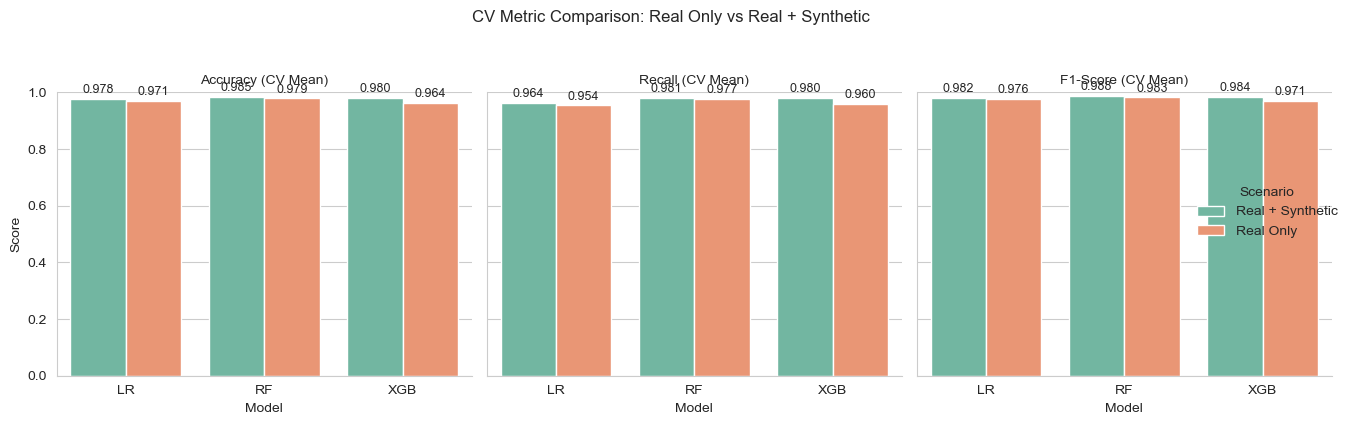

In [15]:
plot_cols = {
    'CV_Accuracy_Mean': 'Accuracy (CV Mean)',
    'CV_Recall_Mean': 'Recall (CV Mean)',
    'CV_F1_Mean': 'F1-Score (CV Mean)',
}

plot_df = summary_df.reset_index()[['Model', 'Scenario'] + list(plot_cols.keys())].copy()
plot_df = plot_df.rename(columns=plot_cols)
plot_df = plot_df.melt(id_vars=['Model', 'Scenario'], var_name='Metric', value_name='Score')

g = sns.catplot(
    data=plot_df,
    x='Model',
    y='Score',
    hue='Scenario',
    col='Metric',
    kind='bar',
    col_wrap=3,
    height=4,
    aspect=1,
    palette='Set2',
    legend_out=True,
)

g.set(ylim=(0, 1))
g.set_axis_labels("Model", "Score")
g.set_titles("{col_name}")
g.fig.suptitle("CV Metric Comparison: Real Only vs Real + Synthetic", y=1.05)

# Add value labels
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=2, fontsize=9)

plt.tight_layout()
plt.show()

## 11. Plot 2: ROC Curve Overlay (CV Out-of-Fold Predictions)


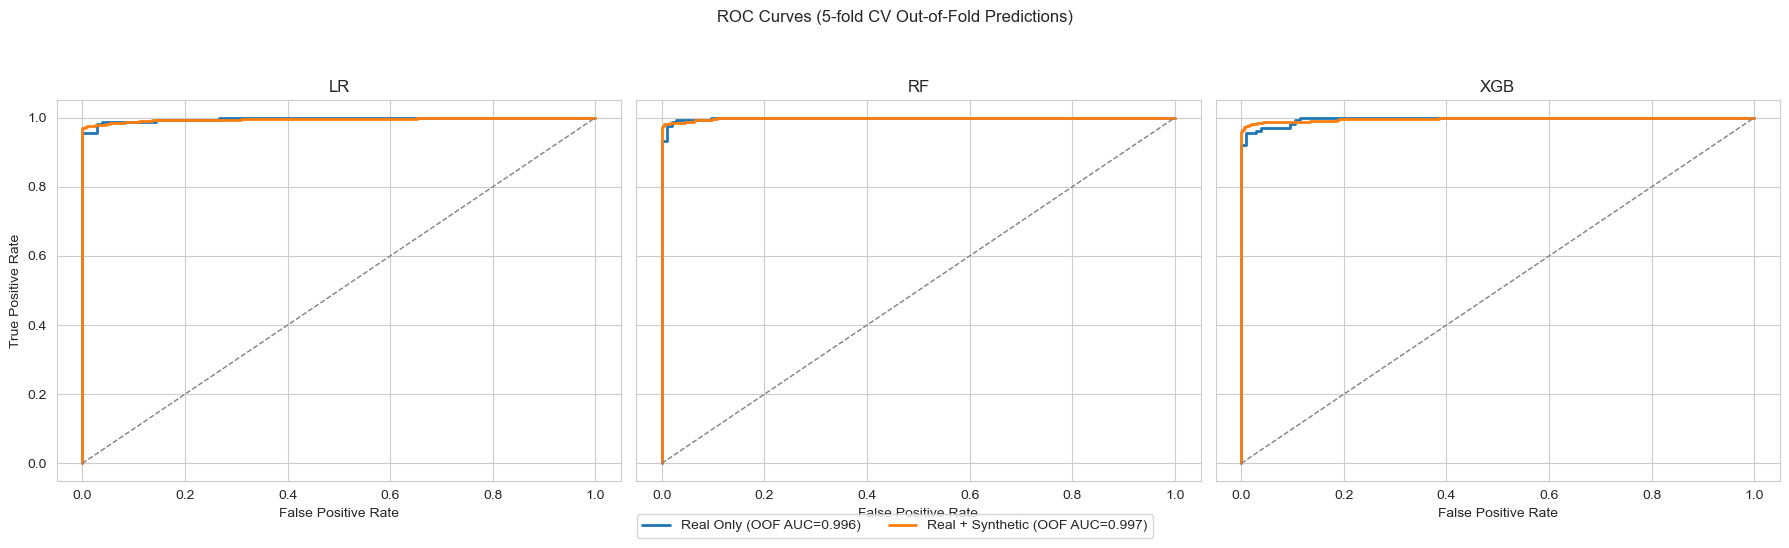

In [16]:
n = len(MODEL_NAMES)
fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), sharey=True)
if n == 1:
    axes = [axes]

handles, labels = None, None
for ax, model_name in zip(axes, MODEL_NAMES):
    for scenario in SCENARIOS:
        info = roc_data[(model_name, scenario)]
        ax.plot(
            info['fpr'],
            info['tpr'],
            linewidth=2,
            label=f"{scenario} (OOF AUC={info['auc']:.3f})",
        )
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1)
    ax.set_title(model_name.upper())
    ax.set_xlabel("False Positive Rate")
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
axes[0].set_ylabel("True Positive Rate")

fig.suptitle("ROC Curves (5-fold CV Out-of-Fold Predictions)", y=1.05)
if handles and labels:
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
plt.tight_layout()
plt.show()

## 12. Plot 3: Side-by-Side Confusion Matrices (CV Out-of-Fold Predictions)


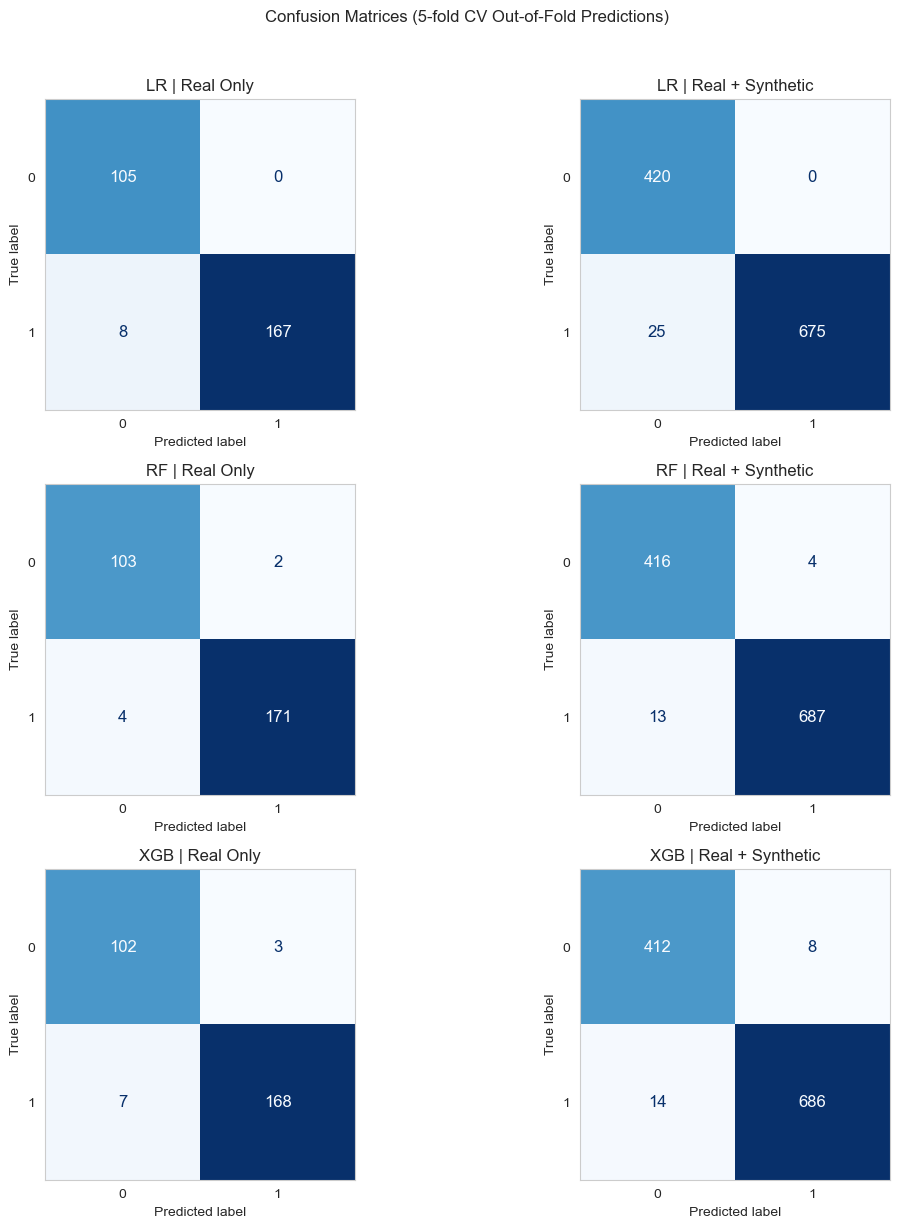

In [17]:
n = len(MODEL_NAMES)
fig, axes = plt.subplots(n, 2, figsize=(12, 4 * n))
if n == 1:
    axes = np.array([axes])

for i, model_name in enumerate(MODEL_NAMES):
    for j, scenario in enumerate(SCENARIOS):
        ax = axes[i, j]
        cm = oof_results[(model_name, scenario)]['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False, text_kw={'fontsize': 12})
        ax.set_title(f"{model_name.upper()} | {scenario}")
        ax.grid(False)

fig.suptitle("Confusion Matrices (5-fold CV Out-of-Fold Predictions)", y=1.02)
plt.tight_layout()
plt.show()